In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import json
import warnings
warnings.filterwarnings('ignore')


In [43]:
import torch
import torch.nn as nn
from torchvision import models

# Extended resnet50 specific to use case
class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)
        num_features = self._get_num_features()
        self._remove_fc_layer()
        self.classifier = self._create_classifier(num_features)

    def _get_num_features(self):
        return self.base_model.fc.in_features

    def _remove_fc_layer(self):
        self.base_model.fc = nn.Identity()

    def _create_classifier(self, input_features):
        return nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(256),
            nn.Linear(256, 15)  # Total 15 classes
        )

    def forward(self, x):
        features = self.base_model(x)
        output = self.classifier(features)
        return output
model = CustomResNet()

In [44]:
class DatasetReader(Dataset):
    def __init__(self, root_dir, annotations_file=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = self._load_annotations(annotations_file)
        self.image_files = self._load_image_files()

    def _load_annotations(self, annotations_file):
        if annotations_file is not None:
            with open(annotations_file, 'r') as file:
                return json.load(file)
        return None
    
    def _get_label(self, image_file):
        label_name = self.annotations[image_file]
        return self._label_to_index(label_name)

    def _label_to_index(self, activity):
        activity_map = {
            'calling': 0,
            'clapping': 1,
            'cycling': 2,
            'dancing': 3,
            'drinking': 4,
            'eating': 5,
            'fighting': 6,
            'hugging': 7,
            'laughing': 8,
            'listening_to_music': 9,
            'running': 10,
            'sitting': 11,
            'sleeping': 12,
            'texting': 13,
            'using_laptop': 14
        }
        return activity_map[activity]

    def _load_image_files(self):
        if self.annotations:
            return list(self.annotations.keys())
        return [f for f in os.listdir(self.root_dir) if os.path.isfile(os.path.join(self.root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.annotations:
            label = self._get_label(self.image_files[idx])
            return image, label
        return image



In [45]:
transform = transforms.Compose([
    transforms.Resize((196,196)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # standard for RGB images
])

train_dataset = DatasetReader('/kaggle/input/human-activity-retrieval/human_activity_retrieval_dataset/train',
                              '/kaggle/input/human-activity-retrieval/human_activity_retrieval_dataset/train_image_info.json',
                              transform)

In [46]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [47]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CustomResNet().to(device)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cuda:0


In [48]:
from sklearn.metrics import accuracy_score
epochs = 10
# Simple training loop for model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        all_labels.extend(labels.cpu().numpy())
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        
        if i % 100 == 99:
            print(f'[Epoch: {epoch + 1}, Batch: {i + 1}] Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
    print(f'End of Epoch {epoch + 1}')

print('Training done')


[Epoch: 1, Batch: 100] Loss: 2.5998
[Epoch: 1, Batch: 200] Loss: 2.3377
[Epoch: 1, Batch: 300] Loss: 2.1966
End of Epoch 1
[Epoch: 2, Batch: 100] Loss: 2.0527
[Epoch: 2, Batch: 200] Loss: 1.9181
[Epoch: 2, Batch: 300] Loss: 1.9005
End of Epoch 2
[Epoch: 3, Batch: 100] Loss: 1.7307
[Epoch: 3, Batch: 200] Loss: 1.7110
[Epoch: 3, Batch: 300] Loss: 1.7970
End of Epoch 3
[Epoch: 4, Batch: 100] Loss: 1.6899
[Epoch: 4, Batch: 200] Loss: 1.9772
[Epoch: 4, Batch: 300] Loss: 1.7622
End of Epoch 4
[Epoch: 5, Batch: 100] Loss: 1.5322
[Epoch: 5, Batch: 200] Loss: 1.5425
[Epoch: 5, Batch: 300] Loss: 1.5344
End of Epoch 5
[Epoch: 6, Batch: 100] Loss: 1.4136
[Epoch: 6, Batch: 200] Loss: 1.4607
[Epoch: 6, Batch: 300] Loss: 1.4158
End of Epoch 6
[Epoch: 7, Batch: 100] Loss: 1.2084
[Epoch: 7, Batch: 200] Loss: 1.2154
[Epoch: 7, Batch: 300] Loss: 1.6259
End of Epoch 7
[Epoch: 8, Batch: 100] Loss: 1.3259
[Epoch: 8, Batch: 200] Loss: 1.7489
[Epoch: 8, Batch: 300] Loss: 1.5189
End of Epoch 8
[Epoch: 9, Batch

In [49]:
import torch

model.eval()
torch.save(model.state_dict(), '/kaggle/working/res_net_50_dict_2.pth')

In [50]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, models

def preprocess_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((196,196)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image

def get_features(model, image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        features = model(image_tensor)
    return features.cpu()

# Function to compute cosine similarity
def cosine_similarity(tensor1, tensor2):
    return torch.nn.functional.cosine_similarity(tensor1, tensor2).item()

# Preprocess and extract features for all images
def extract_features_for_all_images(model, image_paths):
    features = []
    for image_path in tqdm(image_paths):
        image_tensor = preprocess_image(image_path)
        feature = get_features(model, image_tensor)
        features.append(feature)
    return features  # Remove unnecessary dimensions

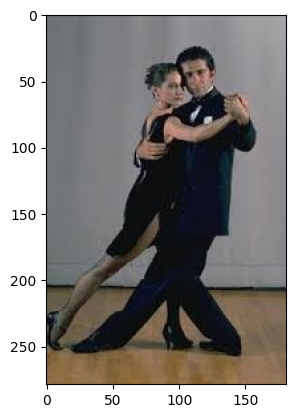

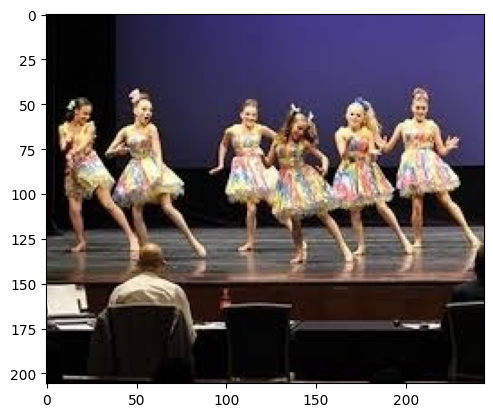

Similarity for given two images is:0.7357389330863953


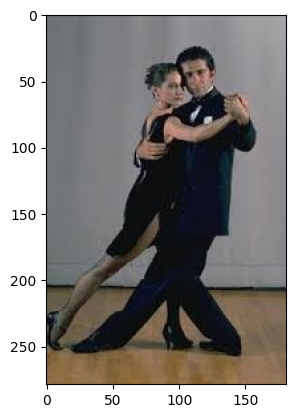

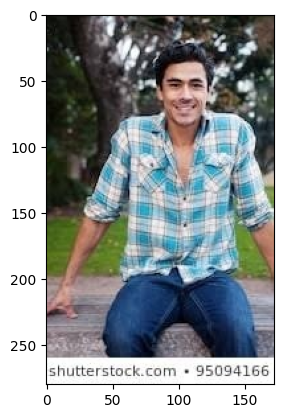

Similarity for given two images is:0.2076469361782074


In [51]:
# Testing on some images if similarity is correctly being predicted
def compare_images(query_img_path, gallery_img_path):
    query_image = Image.open(query_img_path)
    gallery_img = Image.open(gallery_img_path)
    plt.imshow(query_image)
    plt.show()
    plt.imshow(gallery_img)
    plt.show()
    query_image_tensor = preprocess_image(query_img_path)
    gallery_image_tensor = preprocess_image(gallery_img_path)
    features1 = get_features(model, query_image_tensor)
    features2 = get_features(model, gallery_image_tensor)                                  
    # Cosine similarity
    similarity = cosine_similarity(features1, features2)
    print(f"Similarity for given two images is:{similarity}")
    return
                                          
query_img_path = '/kaggle/input/human-activity-retrieval/human_activity_retrieval_dataset/query_images/Image_2000.jpg'
# similar image
gallery_img_path_1 = '/kaggle/input/human-activity-retrieval/human_activity_retrieval_dataset/gallery/Image_2258.jpg'
compare_images(query_img_path, gallery_img_path_1)
# Dissimilar image
gallery_img_path_2 = '/kaggle/input/human-activity-retrieval/human_activity_retrieval_dataset/gallery/Image_2693.jpg'
compare_images(query_img_path, gallery_img_path_2)

In [52]:
# Compute mAP at K
def compute_map_at_k(similarity_matrix, ground_truth, k):
    num_queries = similarity_matrix.shape[0]
    average_precisions = []
    for i in range(num_queries):
        sorted_indices = np.argsort(-similarity_matrix[i])  # Descending order
        relevant_indices = np.where(ground_truth[i] == 1)[0]
        if len(relevant_indices) == 0:
            continue
        hits = 0
        precisions = []
        for rank, idx in enumerate(sorted_indices[:k], start=1):
            if idx in relevant_indices:
                hits += 1
                precisions.append(hits / rank)
        if precisions:
            average_precisions.append(np.mean(precisions))
    return np.mean(average_precisions) if average_precisions else 0

def compute_mean_rank(similarity_matrix, ground_truth):
    num_queries = similarity_matrix.shape[0]
    ranks = []
    for i in range(num_queries):
        sorted_indices = np.argsort(-similarity_matrix[i])  # Descending order
        relevant_indices = np.where(ground_truth[i] == 1)[0]
        if len(relevant_indices) == 0:
            continue
        rank = np.where(sorted_indices == relevant_indices[0])[0][0] + 1
        ranks.append(rank)
    return np.mean(ranks) if ranks else 0


# Load JSON data for image labels
json_path = '/kaggle/input/human-activity-retrieval/human_activity_retrieval_dataset/test_image_info.json'
with open(json_path, 'r') as file:
    image_labels = json.load(file)

# Define paths to gallery and query images
gallery_path = '/kaggle/input/human-activity-retrieval/human_activity_retrieval_dataset/gallery'
query_path = '/kaggle/input/human-activity-retrieval/human_activity_retrieval_dataset/query_images'
gallery_images = os.listdir(gallery_path)
query_images = os.listdir(query_path)

# Assuming `model` and `device` are already defined and the model is loaded onto the device
# Extract features for gallery and query images
gallery_features = extract_features_for_all_images(model, [os.path.join(gallery_path, img) for img in gallery_images])
query_features = extract_features_for_all_images(model, [os.path.join(query_path, img) for img in query_images])

# Compute similarity matrix
similarity_matrix = torch.zeros(len(query_images), len(gallery_images))
for i, query_feature in enumerate(query_features):
    for j, gallery_feature in enumerate(gallery_features):
        similarity_matrix[i, j] = cosine_similarity(query_feature, gallery_feature)

ground_truth = np.zeros((len(query_images), len(gallery_images)))

for i, query_image in enumerate(query_images):
    query_label = image_labels.get(query_image)  # Get the label for the query image
    if query_label is None:
        continue  # Skip if there's no label for the query image
    for j, gallery_image in enumerate(gallery_images):
        gallery_label = image_labels.get(gallery_image)  # Get the label for the gallery image
        if gallery_label is None:
            continue  # Skip if there's no label for the gallery image
        # Check if the gallery image shares the same label with the query image
        if query_label == gallery_label:
            ground_truth[i, j] = 1  # Set the corresponding entry to 1

# Compute mAP at K and mean rank
map_at_1 = compute_map_at_k(similarity_matrix.numpy(), ground_truth, 1)
map_at_10 = compute_map_at_k(similarity_matrix.numpy(), ground_truth, 10)
map_at_50 = compute_map_at_k(similarity_matrix.numpy(), ground_truth, 50)
mean_rank = compute_mean_rank(similarity_matrix.numpy(), ground_truth)

print(f"mAP@1: {map_at_1}")
print(f"mAP@10: {map_at_10}")
print(f"mAP@50: {map_at_50}")
print(f"Mean Rank: {mean_rank}")

100%|██████████| 150/150 [00:01<00:00, 145.15it/s]


mAP@1: 1.0
mAP@10: 0.650003847526665
mAP@50: 0.4817864112498961
Mean Rank: 261.11333333333334
